### OCI Data Science - ML Pipelines sample notebook with ADS

This sample notebook demonstrates how to use ADS to create a pipeline with 3 steps:
 * the first step sets a paramter for the next step
 * the second step creates a data table with the number of rows defined in the first step. generated data is random. the data table is then saved to object storage and the name and location of the data is saved as a paramter for the next step.
 * the third step reads the location of the data and then the data table from the previous step.
 
 Note: the notebook creates the pipeline and runs it, however the code itself for the steps is located in the 3 zip files that should be attached to this notebook.
 
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import oci
import ads
import os
from os import environ
from ads.catalog.project import ProjectCatalog

In [2]:
# make sure you are using ADS version 2.8 or above
print(ads.__version__)

2.8.5


In [3]:
if 'NB_SESSION_COMPARTMENT_OCID' in os.environ:
    # using the notebook's compartment if running on OCI Data Science Notebook Session
    compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
else:
    # set the compartment OCID if you are working locally
    compartment_id = '<YOUR_COMPARTMENT_OCID>'

In [4]:
# this will work whether working on a local machine (using API key) or in OCI Notebook Session (using Resource Principal)
if "OCI_RESOURCE_PRINCIPAL_VERSION" in os.environ:
    # Use resource principal
    print("using Resource Principal for auth")
    ads.set_auth(auth="resource_principal")
else:
    # Use api_key with config file
    print("using API key for auth")
    ads.set_auth(auth="api_key")    

using Resource Principal for auth


In [5]:
# make sure there is access to the project and compartment
pc = ProjectCatalog(compartment_id=compartment_id)
pc.list_projects()

,display_name,description,time_created,lifecycle_state,user_name,compartment_id,freeform_tags,defined_tags
id,,,,,,,,
6sggta,workshop-procco,None,2023-06-06 08:39:21,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
kzikxq,Notartel,All the test for the Face Verification poC in Notartel,2023-04-12 08:43:29,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
6arjeq,Sisal,None,2023-02-23 09:14:29,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
irb5pq,enav-whisper-batch,Strumenti per il training di Whisper con JOBS e pipelines,2023-02-13 09:09:58,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
woqoxa,buildings_segmentation,None,2023-02-01 05:22:15,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
6ybhga,ml_pipelines,"This projects contains all the test done on ML pipelines, since GA Jan 2023",2023-01-30 06:23:07,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
lcsfvq,water_meter,water meter and jobs. Tutti i componenti della soluzione sviluppata inizialmente per l'acquedotto Fiora,2022-12-26 14:22:51,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
6mx6kq,pytorch-on-oci,contiene tutto quanto sviluppato nell'ambito del mio progetto PyTorch on OCI Data Science,2022-10-16 15:28:24,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}
k5ukya,5class-bitron,None,2022-09-18 13:35:01,ACTIVE,,...fe6h3a,{},{'default-tags': {'CreatedBy': 'oracleidentitycloudservice/luigi.saetta@oracle.com'}}


In [6]:
project_id = "ocid1.datascienceproject.oc1.eu-frankfurt-1.amaaaaaangencdyarxbilkubzgqjom3vpr4ejxpp6xtw3blfdvuyhd6sggta"

In [7]:
log_group_id = "ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyazs4l4rzrzsarlej6mqlwlbz6bmnx4adwdlssveam2jaa"

In [8]:
from random import randrange
pipeline_name = f"ads_pipeline_sample_{randrange(1000,9999)}"

## create a new pipeline with ADS

In [9]:
from ads.pipeline.ads_pipeline_step import PipelineStep
from ads.pipeline.ads_pipeline import Pipeline
from ads.pipeline import CustomScriptStep
from ads.jobs import ScriptRuntime

infrastructure = (
    CustomScriptStep()
    .with_block_storage_size(50)
    .with_shape_name("VM.Standard2.4")
)

step_one = (
    PipelineStep("step1")
    .with_description("Pass data by value")
    .with_infrastructure(infrastructure)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step1.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step1.py"
        )
    )
)

step_two = (
    PipelineStep("step2")
    .with_description("pass data by reference")
    .with_infrastructure(infrastructure)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step2.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step2.py"
        )
    )
)

step_three = (
    PipelineStep("step3")
    .with_description("read data by reference")
    .with_infrastructure(infrastructure)
    .with_runtime(
        ScriptRuntime()
        .with_source("mlpipeline_step3.zip")
        .with_service_conda("onnx110_p37_cpu_v1")
        .with_environment_variable(
            PIPELINE_STEP_RUN_ENTRYPOINT="mlpipeline_step3.py"
        )
    )
)

In [10]:
pipeline = (
    Pipeline(pipeline_name)
    .with_compartment_id(compartment_id)
    .with_project_id(project_id)
    .with_log_group_id(log_group_id)  # if you define the LogGroupID but not the LogID, logs will be created automatically in the specified LogGroup
    .with_step_details([step_one, step_two, step_three])
    .with_dag(["step1 >> step2 >> step3"])  # this defines the dependencies between the steps, creating the DAG.                                                     
)                                                   # Use () to define multiple step dependencies, like (step1, step2) >> step3 to run step1 and step2 in parallel and step3 when they both finish

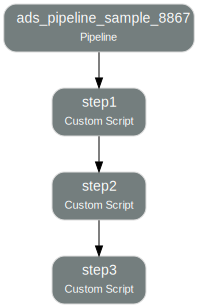

In [11]:
# view the pipeline graph visually, make sure you have the step dependencies defined correctly before creating the pipeline
pipeline.show()

In [12]:
#create the pipeline in the OCI Data Science service. ADS will take care of uploading all the artifacts 
pipeline.create()


kind: pipeline
spec:
  compartmentId: ocid1.compartment.oc1..aaaaaaaag2cpni5qj6li5ny6ehuahhepbpveopobooayqfeudqygdtfe6h3a
  dag:
  - step1 >> step2 >> step3
  displayName: ads_pipeline_sample_8867
  id: ocid1.datasciencepipeline.oc1.eu-frankfurt-1.amaaaaaangencdya4wazs7sxdiwpy2ri3debikucebecblmyct5dpompoveq
  logGroupId: ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyazs4l4rzrzsarlej6mqlwlbz6bmnx4adwdlssveam2jaa
  projectId: ocid1.datascienceproject.oc1.eu-frankfurt-1.amaaaaaangencdyarxbilkubzgqjom3vpr4ejxpp6xtw3blfdvuyhd6sggta
  stepDetails:
  - kind: customScript
    spec:
      description: Pass data by value
      infrastructure:
        kind: infrastructure
        spec:
          blockStorageSize: 50
          shapeName: VM.Standard2.4
      name: step1
      runtime:
        kind: runtime
        spec:
          conda:
            slug: onnx110_p37_cpu_v1
            type: service
          env:
          - name: PIPELINE_STEP_RUN_ENTRYPOINT
            value: mlpipeline_step

In [13]:
# you can export the pipeline to a YAML file and later import it back
pipeline.to_yaml("my_pipeline.yaml")

## Run the pipeline

In [14]:
pipeline_run_name = f"pipeline-run-{randrange(1000,9999)}"

In [15]:
# uncomment the next line and set to the OCI Object Storage location to use for passing data. Make sure you have proper permissions.
data_location = "oci://procco-data@frqap2zhtzbe/"  # use: 'oci://<bucket>@<workspace>/'

In [16]:
# create the pipeline run
pipeline_run = pipeline.run(
    configuration_override_details = {
    "type": "DEFAULT",
    "environment_variables": {"DATA_LOCATION": data_location}
    }
)

In [17]:
print(pipeline_run.status)

ACCEPTED


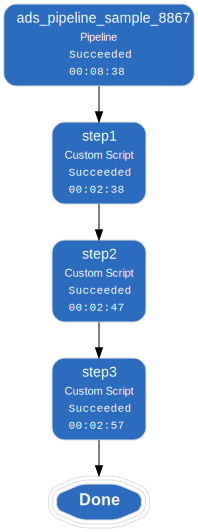

In [18]:
# View the pipeline run graph with status of each step
pipeline_run.show(wait=True)

# you can keep watching the status updates using the following command
#pipeline_run.show(wait=True)

## view logs

In [19]:
pipeline_run.watch() # by default it watches custom logs for all steps
#pipeline_run.watch("step1","step2") # watches custom logs for "step1" and "step2"

Pipeline OCID: ocid1.datasciencepipeline.oc1.eu-frankfurt-1.amaaaaaangencdya4wazs7sxdiwpy2ri3debikucebecblmyct5dpompoveq
Pipeline Run OCID: ocid1.datasciencepipelinerun.oc1.eu-frankfurt-1.amaaaaaangencdyaj64ne2iuvdlwu7pg5h65pcwupki4h7zl6zvih5c2hitq
[C] - custom log
[C] - 2023-06-07 15:12:43 - Before set_pipeline_param
[C] - 2023-06-07 15:12:43 - Job started
[C] - 2023-06-07 15:12:43 - pipeline data file not found. Creating oci://procco-data@frqap2zhtzbe/pipeline_data_ocid1.datasciencepipelinerun.oc1.eu-frankfurt-1.amaaaaaangencdyaj64ne2iuvdlwu7pg5h65pcwupki4h7zl6zvih5c2hitq.csv
[C] - 2023-06-07 15:12:43 - After set_pipeline_param
[C] - 2023-06-07 15:12:43 - Added NUMBER_OF_WORKERS = 4
[C] - 2023-06-07 15:15:33 - Num of workers to create:  4
[C] - 2023-06-07 15:15:34 - Collecting Faker
[C] - 2023-06-07 15:15:34 -   Downloading Faker-18.10.1-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.5 MB/s eta 0:00:0000:016m-:--:--
[C] - 2023-06-07 15:15:34 - R

compartmentId: ocid1.compartment.oc1..aaaaaaaag2cpni5qj6li5ny6ehuahhepbpveopobooayqfeudqygdtfe6h3a
configurationDetails:
  environmentVariables: {}
  type: DEFAULT
configurationOverrideDetails:
  environmentVariables:
    DATA_LOCATION: oci://procco-data@frqap2zhtzbe/
  type: DEFAULT
createdBy: ocid1.datasciencenotebooksession.oc1.eu-frankfurt-1.amaaaaaangencdya7cpgxfxprffrajesv5qgffbdtnnwoajo75uim3gblyzq
definedTags:
  default-tags:
    CreatedBy: ocid1.datasciencenotebooksession.oc1.eu-frankfurt-1.amaaaaaangencdya7cpgxfxprffrajesv5qgffbdtnnwoajo75uim3gblyzq
displayName: ads_pipeline_sample_8867
id: ocid1.datasciencepipelinerun.oc1.eu-frankfurt-1.amaaaaaangencdyaj64ne2iuvdlwu7pg5h65pcwupki4h7zl6zvih5c2hitq
lifecycleDetails: Pipeline run is in progress. Please check the step runs for more
  details.
lifecycleState: SUCCEEDED
logDetails:
  logGroupId: ocid1.loggroup.oc1.eu-frankfurt-1.amaaaaaangencdyazs4l4rzrzsarlej6mqlwlbz6bmnx4adwdlssveam2jaa
  logId: ocid1.log.oc1.eu-frankfurt-1.amaa

## View the pipeline run form the OCI console UI

In [ ]:
print("Ctrl-Click the hyperlink to open the pipeline run page in the OCI console UI")
print("https://cloud.oracle.com/data-science/pipeline-runs/{}".format(pipeline_run.id))

## Delete the pipeline

In [ ]:
#delete the pipeline when done
pipeline.delete(delete_related_pipeline_runs=True, delete_related_job_runs=True)  # delete also all the pipeline runs and job runs in the pipeline, otherwise those have to be deleted before deleting the pipeline